In [1]:
import datetime
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
from dateutil import tz
import os

from salishsea_tools import nc_tools, stormtools
from nowcast import figures

%matplotlib inline

In [2]:
f = nc.Dataset('/ocean/nsoontie/MEOPAR/JP_SSH/SSH_N06_NANCY/NEP036-N06_IN_20140102_00000720_grid_2D.nc')

ssh = f.variables['sossheig'][:]
time = f.variables['time_counter']
dates = nc.num2date(time[:], time.units)

lats= f.variables['nav_lat'][:]
lons = f.variables['nav_lon'][:]


Where is the data?

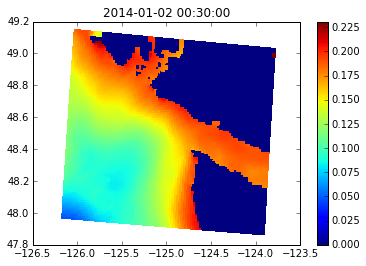

In [3]:
t=0
plt.pcolormesh(lons,lats,ssh[t,:,:])
plt.colorbar()
plt.title(dates[t])

I can possibly check ssh for Tofino, Bamfield, Neah Bay.. Maybe some more NOAA stations.

# Plot time series

In [4]:
f=nc.MFDataset('/ocean/nsoontie/MEOPAR/JP_SSH/SSH_N06_NANCY/*.nc')
SITES=figures.SITES

In [5]:
tols = {'Neah Bay': (.0045,.03), 'Tofino': (0.008,0.06), 'Bamfield': (0.005,0.06)}
names = ['Neah Bay', 'Tofino', 'Bamfield'] 
sshs = {}
for name in names:
    j,i = figures.find_model_point(SITES[name]['lon'], SITES[name]['lat'],
                              lons, lats, tol_lon =tols[name][0], tol_lat = tols[name][1])
    sshs[name] = f.variables['sossheig'][:,j,i]
times = f.variables['time_counter']
dates=nc.num2date(times[:], time.units)
dates = [ d.replace(tzinfo=tz.tzutc()) for d in dates]

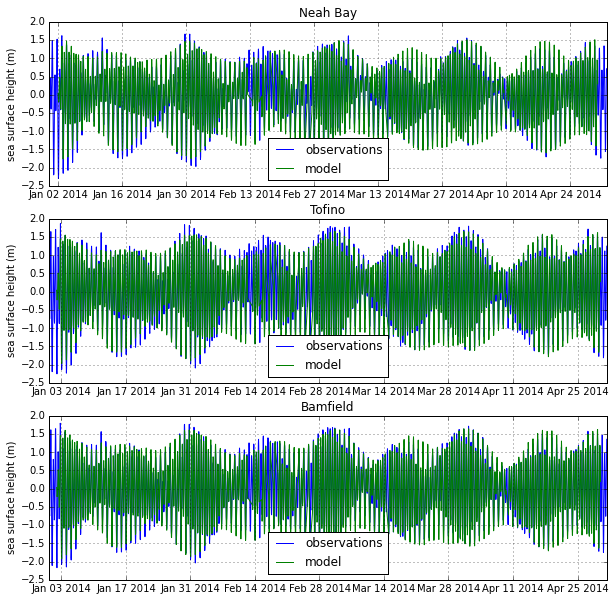

In [6]:
sdt = datetime.datetime(2013,12,31)
edt = datetime.datetime(2014,5,1)
fig, axs = plt.subplots(3,1,figsize=(10,10))
for name,ax in zip(names, axs):
    if name == 'Neah Bay':
        obs = figures.get_NOAA_wlevels(SITES[name]['stn_no'], 
                                      sdt.strftime('%d-%b-%Y'), edt.strftime('%d-%b-%Y'),
                                      product='hourly_height')
    else:    
        obs = figures.load_archived_observations(name, sdt.strftime('%d-%b-%Y'), edt.strftime('%d-%b-%Y'))
    ax.plot(obs.time, obs.wlev - np.mean(obs.wlev),label = 'observations')
    ax.plot(dates, sshs[name][:,0,0]-np.mean(sshs[name][:,0,0]), label = 'model')
    ax.set_title(name)
    ax.set_ylabel('sea surface height (m)')
    ax.legend(loc=0)
    ax.grid()

# Residual time series

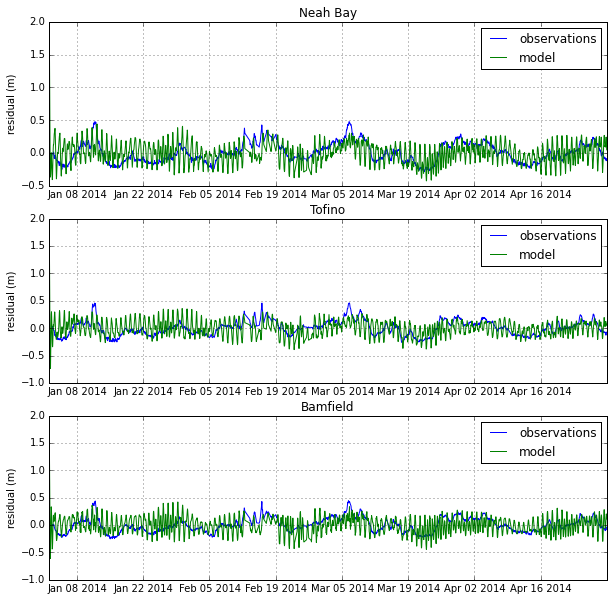

In [7]:
tide_path = '/data/nsoontie/MEOPAR/analysis/storm_surges/data/'
sdt = datetime.datetime(2013,12,31)
edt = datetime.datetime(2014,5,1)
fig, axs = plt.subplots(3,1,figsize=(10,10))
for name,ax in zip(names, axs):
    if name == 'Neah Bay':
        obs = figures.get_NOAA_wlevels(SITES[name]['stn_no'], 
                                      sdt.strftime('%d-%b-%Y'), edt.strftime('%d-%b-%Y'),
                                      product='hourly_height')
    else:    
        obs = figures.load_archived_observations(name, sdt.strftime('%d-%b-%Y'), edt.strftime('%d-%b-%Y'))
    tides, msl = stormtools.load_tidal_predictions(
        os.path.join(tide_path,'{}_tidal_prediction_31-Dec-2013_01-Jan-2015.csv'.format(name)))
    obs_interp = np.array(figures.interp_to_model_time(dates, obs.wlev, obs.time))
    tides_interp = np.array(figures.interp_to_model_time(dates, tides.pred_all, tides.time))
    res_obs = obs_interp -np.mean(obs_interp) - tides_interp
    res_model = sshs[name][:,0,0]  - np.mean(sshs[name][:,0,0]) - tides_interp
    ax.plot(dates, res_obs,label = 'observations')
    ax.plot(dates, res_model, label = 'model')
    ax.set_title(name)
    ax.set_ylabel('residual (m)')
    ax.legend(loc=0)
    ax.grid()

* Should check in witih JP about constituents used in the model. It would be useful to know which constituents are used and decide if we can apply a correction to make up for the missing constituents...
* Alternatively, it may be better to do a harmonic analysis on the model water levels and then calculate model residuals with a true picture of the model tides.
* It looks to me like the ampltiude of the missing tidal energy can be as large as the surges. But again, this might be an unfair comparison.

# Scatter - water level

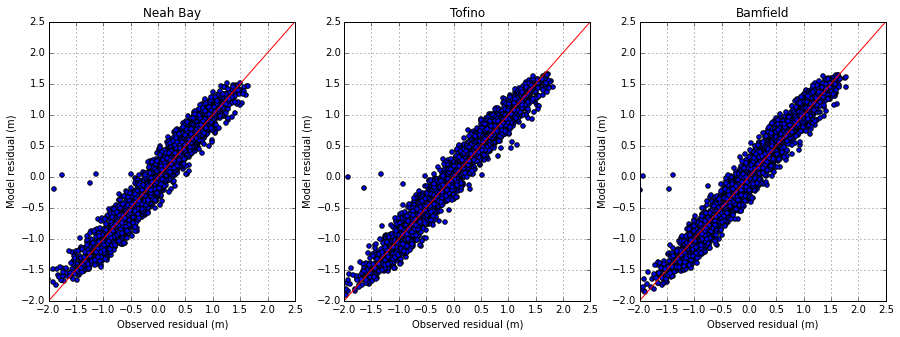

In [8]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
for name,ax in zip(names, axs):
    if name == 'Neah Bay':
        obs = figures.get_NOAA_wlevels(SITES[name]['stn_no'], 
                                      sdt.strftime('%d-%b-%Y'), edt.strftime('%d-%b-%Y'),
                                      product='hourly_height')
    else:    
        obs = figures.load_archived_observations(name, sdt.strftime('%d-%b-%Y'), edt.strftime('%d-%b-%Y'))
    tides, msl = stormtools.load_tidal_predictions(
        os.path.join(tide_path,'{}_tidal_prediction_31-Dec-2013_01-Jan-2015.csv'.format(name)))
    
    obs_interp = np.array(figures.interp_to_model_time(dates, obs.wlev, obs.time))
    ax.scatter(obs_interp -np.mean(obs_interp) , sshs[name][:,0,0]  - np.mean(sshs[name][:,0,0]))
    ax.set_title(name)
    ax.set_ylabel('Model residual (m)')
    ax.set_xlabel('Observed residual (m)')
    ax.grid()
    ax.set_ylim([-2,2.5])
    ax.set_xlim([-2,2.5])
    ax.plot([-2,2.5],[-2,2.5],'r-')

Weird outliers where the model goes close to zero.

# Scatter - residuals

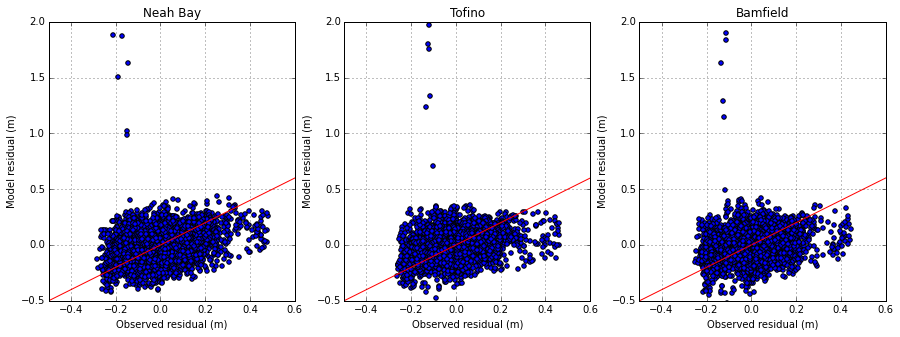

In [9]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
for name,ax in zip(names, axs):
    if name == 'Neah Bay':
        obs = figures.get_NOAA_wlevels(SITES[name]['stn_no'], 
                                      sdt.strftime('%d-%b-%Y'), edt.strftime('%d-%b-%Y'),
                                      product='hourly_height')
    else:    
        obs = figures.load_archived_observations(name, sdt.strftime('%d-%b-%Y'), edt.strftime('%d-%b-%Y'))
    tides, msl = stormtools.load_tidal_predictions(
        os.path.join(tide_path,'{}_tidal_prediction_31-Dec-2013_01-Jan-2015.csv'.format(name)))
    
    obs_interp = np.array(figures.interp_to_model_time(dates, obs.wlev, obs.time))
    tides_interp = np.array(figures.interp_to_model_time(dates, tides.pred_all, tides.time))
    res_obs = obs_interp -np.mean(obs_interp) - tides_interp
    res_model = sshs[name][:,0,0]  - np.mean(sshs[name][:,0,0]) - tides_interp
    ax.scatter(res_obs, res_model)
    ax.set_title(name)
    ax.set_ylabel('Model residual (m)')
    ax.set_xlabel('Observed residual (m)')
    ax.grid()
    ax.set_ylim([-.5,2])
    ax.set_xlim([-.5,.6])
    ax.plot([-.5,1],[-.5,1],'r-')

# Error - time series

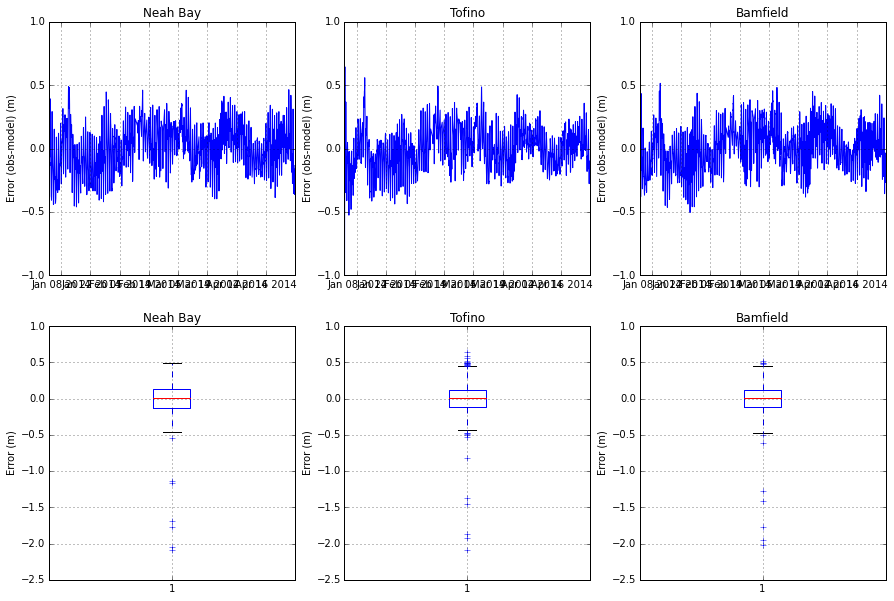

In [10]:
fig, axs = plt.subplots(2,3,figsize=(15,10))
for name,ax, axb in zip(names, axs[0,:], axs[1,:]):
    if name == 'Neah Bay':
        obs = figures.get_NOAA_wlevels(SITES[name]['stn_no'], 
                                      sdt.strftime('%d-%b-%Y'), edt.strftime('%d-%b-%Y'),
                                      product='hourly_height')
    else:    
        obs = figures.load_archived_observations(name, sdt.strftime('%d-%b-%Y'), edt.strftime('%d-%b-%Y'))
    
    obs_interp = np.array(figures.interp_to_model_time(dates, obs.wlev, obs.time))
    error = obs_interp - np.mean(obs_interp) - (sshs[name][:,0,0] - np.mean(sshs[name][:,0,0]))
    ax.plot(dates, error)
    ax.set_title(name)
    ax.set_ylabel('Error (obs-model) (m)')
    ax.set_ylim([-1,1])
    ax.grid()
    
    axb.boxplot(error)
    axb.set_title(name)
    axb.set_ylabel('Error (m)')
    axb.grid()
    axb.set_ylim([-2.5,1])

Other statistics can follow